In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install shap tensorflow

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import shap

In [4]:
df = pd.read_csv("/content/drive/MyDrive/energy_efficiency_data.csv")
df.head(10)

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Heating_Load,Cooling_Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28
5,0.90,563.5,318.5,122.50,7.0,3,0.0,0,21.46,25.38
6,0.90,563.5,318.5,122.50,7.0,4,0.0,0,20.71,25.16
7,0.90,563.5,318.5,122.50,7.0,5,0.0,0,19.68,29.60
8,0.86,588.0,294.0,147.00,7.0,2,0.0,0,19.50,27.30
9,0.86,588.0,294.0,147.00,7.0,3,0.0,0,19.95,21.97


In [5]:
# Rename columns
df.columns = [
    "Relative_Compactness", "Surface_Area", "Wall_Area", "Roof_Area",
    "Overall_Height", "Orientation", "Glazing_Area", "Glazing_Area_Distribution",
    "Heating_Load", "Cooling_Load"
]

In [6]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Relative_Compactness       768 non-null    float64
 1   Surface_Area               768 non-null    float64
 2   Wall_Area                  768 non-null    float64
 3   Roof_Area                  768 non-null    float64
 4   Overall_Height             768 non-null    float64
 5   Orientation                768 non-null    int64  
 6   Glazing_Area               768 non-null    float64
 7   Glazing_Area_Distribution  768 non-null    int64  
 8   Heating_Load               768 non-null    float64
 9   Cooling_Load               768 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 60.1 KB
None
       Relative_Compactness  Surface_Area   Wall_Area   Roof_Area  \
count            768.000000    768.000000  768.000000  768.000000   
mean               0.764167  

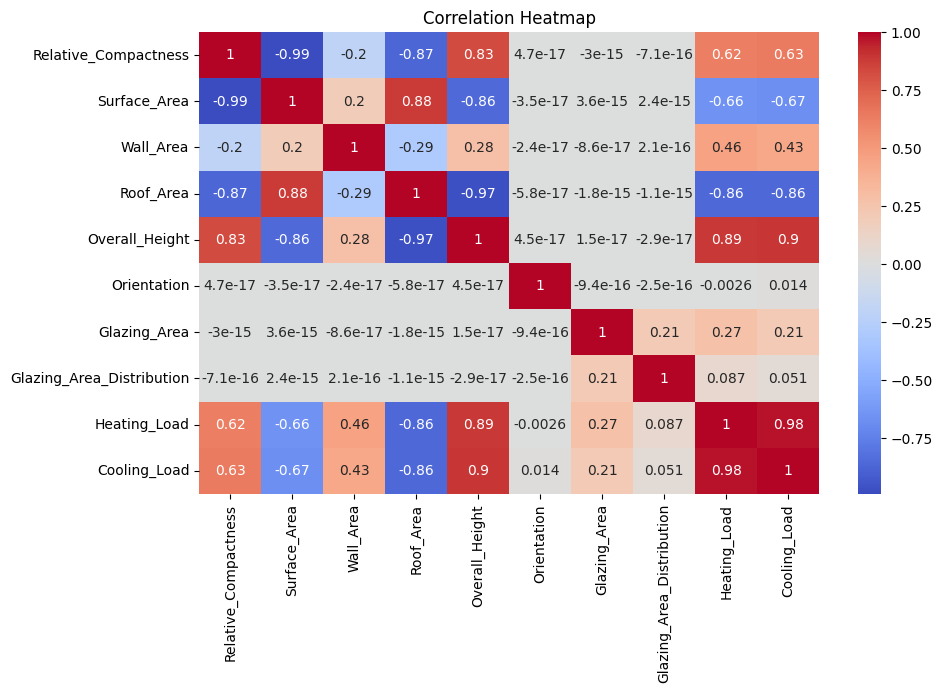

In [7]:
# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

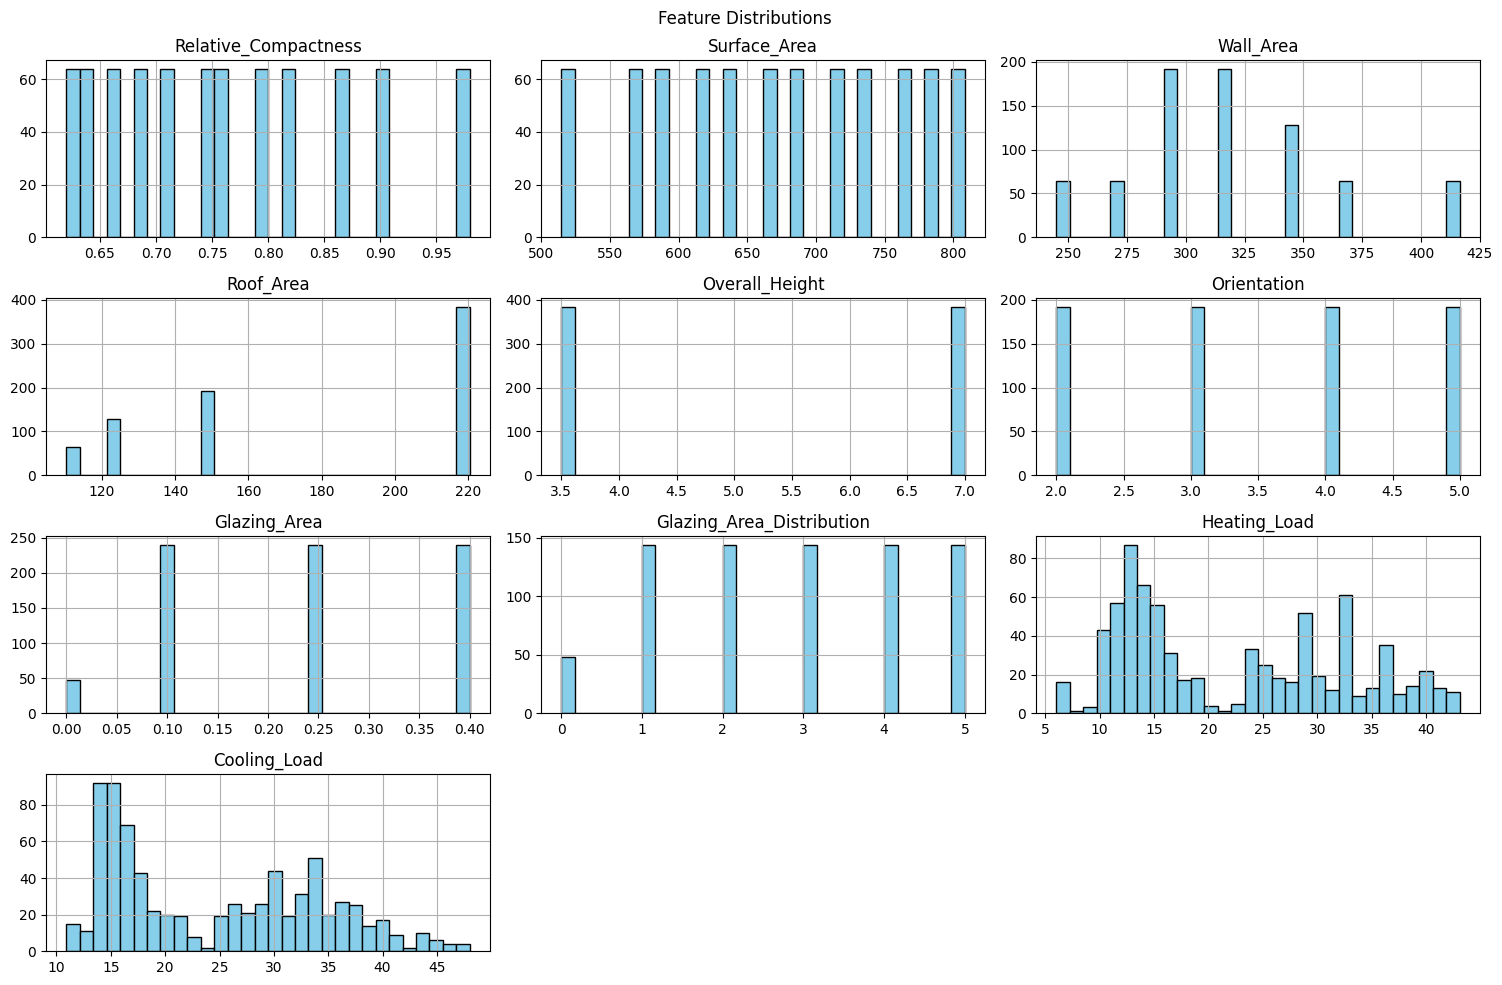

In [8]:
# Histograms
df.hist(bins=30, figsize=(15, 10), color='skyblue', edgecolor='black')
plt.suptitle("Feature Distributions")
plt.tight_layout()
plt.show()

In [9]:
# Preprocessing
X = df.drop(['Heating_Load', 'Cooling_Load'], axis=1)
y = df[['Heating_Load', 'Cooling_Load']]

In [10]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
# Linear Regression (No Regularization)
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
lr_preds = lr.predict(X_test_scaled)
lr_r2 = r2_score(y_test, lr_preds)

In [13]:
# Ridge Regression with GridSearchCV
ridge_params = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}
ridge = Ridge()
ridge_grid = GridSearchCV(ridge, ridge_params, cv=5, scoring='r2')
ridge_grid.fit(X_train_scaled, y_train)
ridge_preds = ridge_grid.predict(X_test_scaled)
ridge_r2 = r2_score(y_test, ridge_preds)

print(f"Best alpha for Ridge: {ridge_grid.best_params_}")

Best alpha for Ridge: {'alpha': 0.1}


In [14]:
# Random Forest Regressor with GridSearchCV
rf = RandomForestRegressor(random_state=42)
rf_params = {'n_estimators': [50, 100],
             'max_depth': [None, 10, 20],
             'min_samples_split': [2, 5]}

rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='r2', n_jobs=-1)
rf_grid.fit(X_train, y_train)  # no scaling
rf_preds = rf_grid.predict(X_test)
rf_r2 = r2_score(y_test, rf_preds)

print(f"Best params for Random Forest: {rf_grid.best_params_}")

Best params for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}


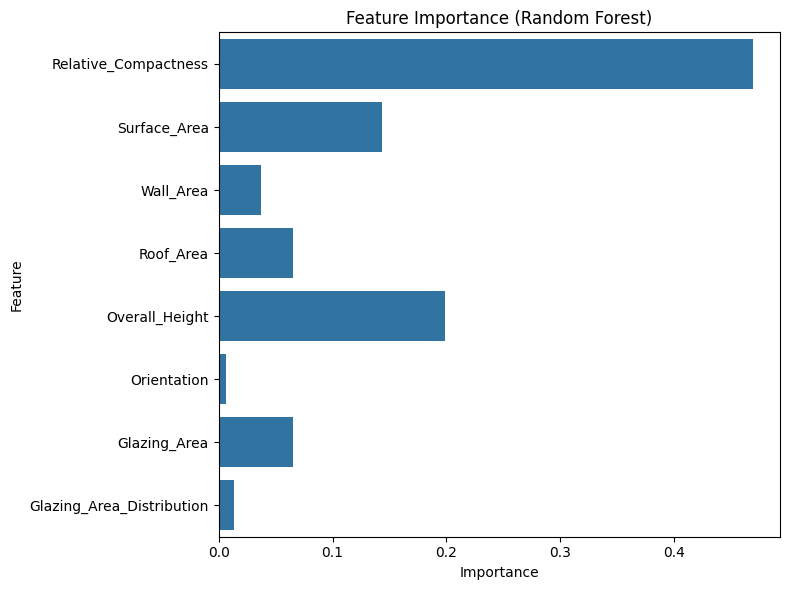

In [15]:
# Feature Importance from Random Forest
importances = rf_grid.best_estimator_.feature_importances_
features = X.columns

plt.figure(figsize=(8, 6))
sns.barplot(x=importances, y=features)
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [16]:
# Build model for two outputs
def build_multitarget_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(2)  # Two outputs: Heating_Load and Cooling_Load
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

# Train model
multi_model = build_multitarget_model(X_train_scaled.shape[1])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

history_multi = multi_model.fit(X_train_scaled, y_train, validation_split=0.2,
                                epochs=150, batch_size=16, verbose=0, callbacks=[early_stop])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 116: early stopping
Restoring model weights from the end of the best epoch: 106.


In [17]:
multi_preds = multi_model.predict(X_test_scaled)

pred_heat = multi_preds[:, 0]
pred_cool = multi_preds[:, 1]

true_heat = y_test['Heating_Load'].values
true_cool = y_test['Cooling_Load'].values

r2_heat = r2_score(true_heat, pred_heat)
r2_cool = r2_score(true_cool, pred_cool)

print(f"🔹 Heating Load R²: {r2_heat:.4f}")
print(f"🔹 Cooling Load R²: {r2_cool:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
🔹 Heating Load R²: 0.9842
🔹 Cooling Load R²: 0.9547


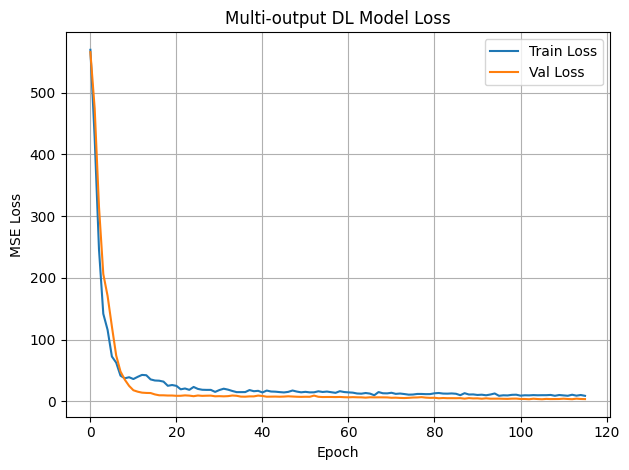

In [18]:
plt.plot(history_multi.history['loss'], label='Train Loss')
plt.plot(history_multi.history['val_loss'], label='Val Loss')
plt.title("Multi-output DL Model Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<ipython-input-19-257dd53b9635>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='R2 Score', y='Model', data=results, palette='magma')


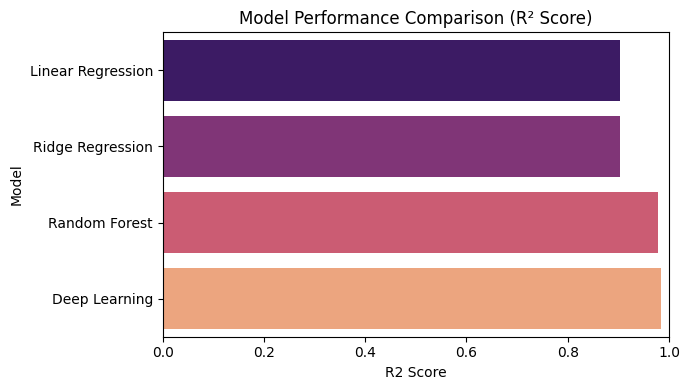

Best model based on R² score: Deep Learning


In [19]:
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge Regression', 'Random Forest', 'Deep Learning'],
    'R2 Score': [lr_r2, ridge_r2, rf_r2, r2_heat]
})

# Plot best model
plt.figure(figsize=(7,4))
sns.barplot(x='R2 Score', y='Model', data=results, palette='magma')
plt.title("Model Performance Comparison (R² Score)")
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

best_model_name = results.loc[results['R2 Score'].idxmax(), 'Model']
print(f"Best model based on R² score: {best_model_name}")